<a href="https://colab.research.google.com/github/soumya-kole/bigquery/blob/main/BigQueryNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'bigqueryproject-406400' # Project ID inserted based on the query results selected to explore
location = 'southamerica-west1' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

# Number of vaccinations Over Time by Country

In [33]:

job = client.get_job('bquxjob_342bb2d5_18c0ee0b83c') # Job ID inserted based on the query results selected to explore
print(job.query)
results = job.to_dataframe()
results.head()

-- SELECT 
-- 	country,
-- 	date,
-- 	daily_vaccinations
-- FROM
-- 	`bigqueryproject-406400.data_analysis.country_vaccinations`
--   where country='Afghanistan'
-- 	and date='2021-02-22'

SELECT 
	country As Country,
	extract(year from date) as Year,
	extract(month from date) as Month,
	SUM(daily_vaccinations) AS Num_vaccinations
FROM 
	`bigqueryproject-406400.data_analysis.country_vaccinations`
WHERE 
	country IN ('England', 'India', 'United States')
GROUP BY 
	Country, Year, Month
ORDER BY 1,2,3



,Country,Year,Month,Num_vaccinations
0,England,2021,1,5600174.0
1,England,2021,2,9377418.0
2,England,2021,3,11861175.0
3,England,2021,4,11288945.0
4,England,2021,5,13772946.0


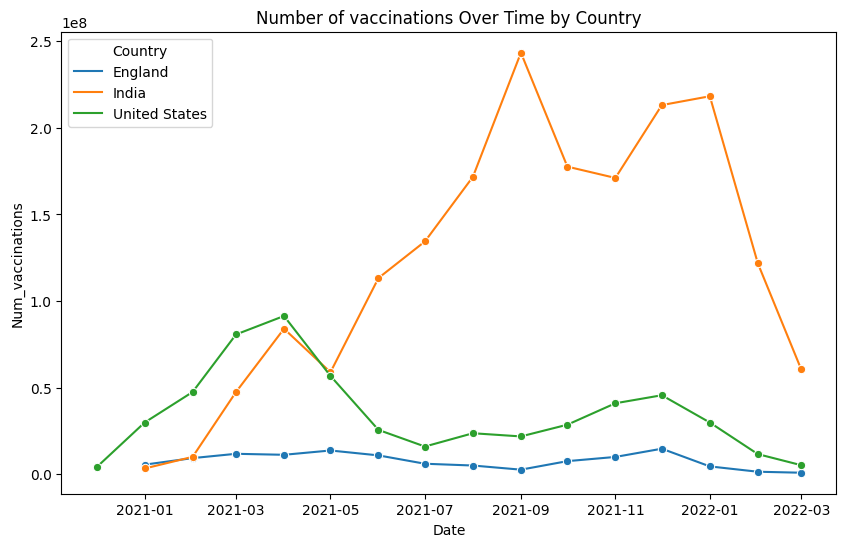

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results['Date'] = pd.to_datetime(results[['Year', 'Month']].assign(DAY=1))

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Num_vaccinations', hue='Country', data=results, marker='o')
plt.title('Number of vaccinations Over Time by Country')
plt.xlabel('Date')
plt.ylabel('Num_vaccinations')
plt.legend(title='Country')
plt.show()


### Three months moving average

In [37]:
job = client.get_job('bquxjob_3e7ac297_18c0f20b970') # Job ID inserted based on the query results selected to explore
print(job.query)
three_months_ma_df = job.to_dataframe()
three_months_ma_df.head()

with cte as (
  select country,
  format_date('%Y-%m', date) as yr_month,
  sum(daily_vaccinations) as monthly_vaccination
  from `bigqueryproject-406400.data_analysis.country_vaccinations`
  WHERE country IN ('England', 'India', 'United States')
  group by 1,2
) 
select country,
yr_month,
round(avg(monthly_vaccination) over(partition by country order by yr_month rows between 2 preceding and current row), 2)  as three_month_ma
from cte



,country,yr_month,three_month_ma
0,India,2021-01,3379485.00
1,India,2021-02,6741558.00
2,India,2021-03,20334091.67
3,India,2021-04,47219560.00
4,India,2021-05,63497162.00


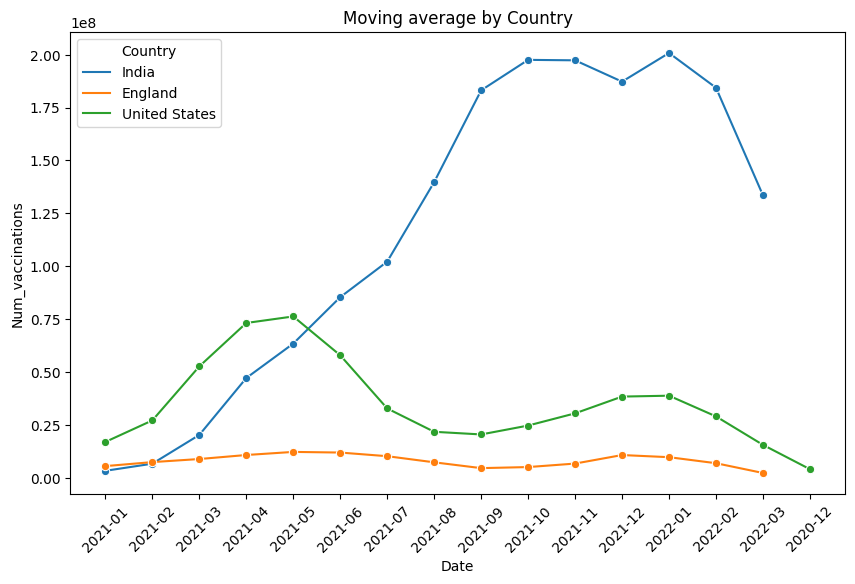

In [38]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='yr_month', y='three_month_ma', hue='country', data=three_months_ma_df, marker='o')
plt.title('Moving average by Country')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Num_vaccinations')
plt.legend(title='Country')
plt.show()


In [ ]:
### Month by month percentage change per country

In [39]:
job = client.get_job('bquxjob_74f67b34_18c0f36c605') # Job ID inserted based on the query results selected to explore
print(job.query)
percent_change = job.to_dataframe()
percent_change.head()

with monthly as (
  select country,
  extract(year from date) as year,
  extract(month from date) as month,
  sum(daily_vaccinations) as monthly_vaccination
  from `bigqueryproject-406400.data_analysis.country_vaccinations`
  WHERE country IN ('England', 'India', 'United States')
  group by 1,2,3
), cte as (
select *,
coalesce(lag(monthly_vaccination) over(partition by country order by year, month),0) as previous_month
from monthly)
select 
  country, 
  year,
  month,
  case 
  when previous_month=0 then 100
  else round(((monthly_vaccination-previous_month)/previous_month)*100,2) 
  end as percentage_change
  from cte



,country,year,month,percentage_change
0,India,2021,1,100.00
1,India,2021,2,198.97
2,India,2021,3,370.32
3,India,2021,4,76.85
4,India,2021,5,-29.87


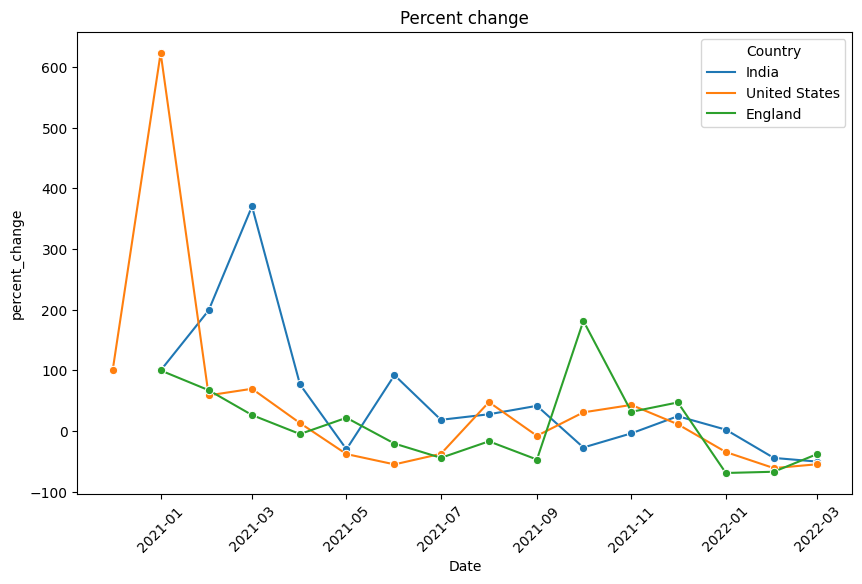

In [24]:
percent_change['Date'] = pd.to_datetime(percent_change[['year', 'month']].assign(DAY=1))
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='percentage_change', hue='country', data=percent_change, marker='o')
plt.title('Percent change')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('percent_change')
plt.legend(title='Country')
plt.show()


### Running total of vaccinations accross countries

In [41]:
job = client.get_job('bquxjob_54d9d7da_18c0f89e97a') # Job ID inserted based on the query results selected to explore
print(job.query)
rt = job.to_dataframe()
rt.head()

with cte as (
select 
  format_date('%Y-%m', date) as yr_month,
  sum(daily_vaccinations) as monthly_vaccination
from `bigqueryproject-406400.data_analysis.country_vaccinations`
group by 1
)
select 
  yr_month,
  sum(monthly_vaccination) over(order by yr_month) as running_total
from cte




,yr_month,running_total
0,2020-12,8.707900e+06
1,2021-01,1.022304e+08
2,2021-02,2.731909e+08
3,2021-03,6.163911e+08
4,2021-04,1.152004e+09


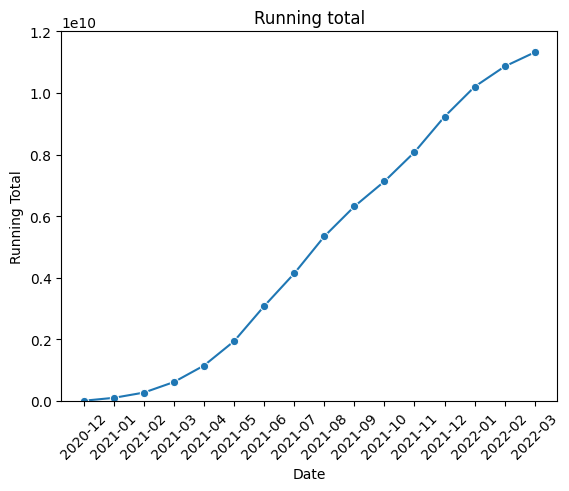

In [42]:
sns.lineplot(x='yr_month', y='running_total', data=rt, marker='o')
plt.title('Running total')
plt.ylim(0, 12000000000)
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Running Total')
plt.show()
